# 📋 Full Step-by-Step Implementation Plan for KGGDM

⸻

### Phase 1: Environment Setup

	1.	Set up Google Colab environment
Install required libraries:
	•	torch, torchvision, diffusers, transformers, accelerate
	•	pykeen (for TransE knowledge graph embeddings)
	•	torchmetrics (for evaluation metrics like FID, IS)
	•	timm (for classifier training, optional)
	•	(Optional) Mount Google Drive for saving models/checkpoints.

⸻

### Phase 2: Dataset Preparation (CelebA)
	2.	Download the CelebA dataset
	•	Use Kaggle API or alternative download link.
	•	Extract:
	•	img_align_celeba/ (images)
	•	list_attr_celeba.txt (attribute labels)
	3.	Preprocess the CelebA images
	•	Center-crop and resize all images to 256x256.
	•	Normalize images (scale pixel values from [0,255] to [-1,1]).
	4.	Load and parse attribute metadata
	•	Read list_attr_celeba.txt into a Pandas DataFrame.
	•	Each image has 40 binary attributes (+1 present, -1 absent).

⸻

### Phase 3: Knowledge Graph (KG) Construction
	5.	Design an ontology
	•	Group attributes into logical categories (Hair, Makeup, Accessories, etc.).
	6.	Build knowledge graph triples
	•	For each image and each attribute (where attribute=1):
	•	Create triples: (Image_ID, relation, Attribute).
	•	(Optional) Add ontology-level triples if needed.
	7.	Save all triples
	•	Prepare triples in a format compatible with PyKEEN (list or NumPy array).

⸻

### Phase 4: Knowledge Graph Embedding (TransE)
	8.	Train a TransE model using PyKEEN
	•	Feed KG triples to PyKEEN’s TriplesFactory.
	•	Train TransE model to learn entity/relation embeddings.
	•	Save the trained TransE model.
	9.	Extract attribute embeddings
	•	For each of the 40 CelebA attributes, extract its learned vector (d-dimensional, e.g., d=50).

⸻

### Phase 5: Feature Compaction (Autoencoder)
	10.	Construct per-image attribute vectors
	•	For each image:
	•	Multiply attribute embeddings by +1/-1 based on the attribute label.
	•	Concatenate into a single vector (shape: 40 × d).
	11.	Design an autoencoder
	•	Encoder: Compress 40×d input into a latent_dim vector (e.g., 128-dim).
	•	Decoder: Reconstruct the original 40×d vector.
	12.	Train the autoencoder
	•	Minimize reconstruction error (MSE loss).
	•	Save the trained autoencoder model.
	13.	Compress attribute vectors
	•	Pass the per-image attribute vectors through the autoencoder encoder to obtain compressed 128-dim vectors.

⸻

### Phase 6: Stable Diffusion Modification
	14.	Load a pre-trained Stable Diffusion model
	•	Use Hugging Face’s diffusers library (runwayml/stable-diffusion-v1-5 or similar).
	15.	Add a conditioning projection layer
	•	Project compressed 128-dim vectors to 768-dim (the dimension used for cross-attention conditioning).
	16.	Prepare latent-space training data
	•	Encode images using the VAE encoder to obtain latents.
	•	Match each latent with its compressed attribute conditioning vector.

⸻

### Phase 7: Fine-tuning the Diffusion Model
	17.	Train Stable Diffusion with KG conditioning
	•	Add noise to latents based on random timesteps.
	•	Train U-Net to predict noise conditioned on KG attribute embeddings.
	•	Use MSE loss between predicted and true noise.
	•	Train U-Net + projection layer.
	18.	Save the fine-tuned model
	•	Save updated U-Net weights and projection layer.

⸻

### Phase 8: Inference (Image Generation)
	19.	Generate images
	•	Given a desired set of attributes (Smiling, Male, Blond Hair, etc.):
	•	Build attribute vector → Compress → Project to 768-dim → Condition diffusion model.
	•	Generate and save images.

⸻

### Phase 9: Evaluation
	20.	Evaluate with FID and IS
	•	Generate a batch of fake images.
	•	Compare with real CelebA images to compute:
	•	Fréchet Inception Distance (FID).
	•	Inception Score (IS).
	21.	Evaluate conditional attribute accuracy
	•	Train a simple classifier (ResNet50 or similar) to predict attributes.
	•	Check if generated images match requested attributes.

⸻

### Phase 10: Ablation Studies
	22.	Train baselines for comparison
	•	Unconditional diffusion model (no attribute conditioning).
	•	Attribute-conditioned diffusion without KG embeddings (using raw attributes directly).
	23.	Compare results
	•	FID, IS, and conditional accuracy.
	•	Show that KG conditioning improves controllability and image quality.

⸻

### ✅ Summary of the 23 Key Steps:
	•	1-4: Dataset preparation
	•	5-7: Knowledge graph construction
	•	8-9: Train TransE
	•	10-13: Train Autoencoder
	•	14-16: Load and modify Stable Diffusion
	•	17-18: Fine-tune diffusion model
	•	19: Inference (generation)
	•	20-21: Evaluation
	•	22-23: Ablation study

In [ ]:
### 1. Download DataSet from Keggle

In [ ]:
# Install gdown for Google Drive downloads
!pip install -q gdown

import os

# 1. Create a directory for the dataset
DATA_DIR = "/content/celebA"
#os.makedirs(DATA_DIR, exist_ok=True)

# 2. Download the aligned & cropped images archive
#!gdown --id 0B7EVK8r0v71pZjFTYXZWM3FlRnM -O {DATA_DIR}/img_align_celeba.zip

# 3. Download the facial attribute annotations
#!gdown --id 0B7EVK8r0v71pblRyaVFSWGxPY0U -O {DATA_DIR}/list_attr_celeba.txt

# 4. Unzip the images
#!unzip -q {DATA_DIR}/img_align_celeba.zip -d {DATA_DIR}

# 5. (Optional) Load and inspect the attributes with pandas
import pandas as pd

# The first line is the total number of images; the second is the 40 attribute names
attr_df = pd.read_csv(
    f"{DATA_DIR}/list_attr_celeba.txt",
    delim_whitespace=True,
    header=1,
    index_col=0
)

print(attr_df.head())


<ipython-input-5-1635d0b82702>:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  attr_df = pd.read_csv(


            5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
000001.jpg                -1                1           1               -1   
000002.jpg                -1               -1          -1                1   
000003.jpg                -1               -1          -1               -1   
000004.jpg                -1               -1           1               -1   
000005.jpg                -1                1           1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
000001.jpg    -1     -1        -1        -1          -1          -1  ...   
000002.jpg    -1     -1        -1         1          -1          -1  ...   
000003.jpg    -1     -1         1        -1          -1          -1  ...   
000004.jpg    -1     -1        -1        -1          -1          -1  ...   
000005.jpg    -1     -1         1        -1          -1          -1  ...   

            Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings

In [ ]:
attr_df.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,...,202599.000000,202599.000000,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,-0.777728,-0.466039,0.02501,-0.590857,-0.955113,-0.696849,-0.518408,-0.530935,-0.521498,-0.704016,...,-0.886979,-0.035839,-0.583196,-0.360866,-0.62215,-0.903079,-0.055129,-0.754066,-0.854570,0.547234
std,0.628602,0.884766,0.99969,0.806778,0.296241,0.717219,0.855135,0.847414,0.853255,0.710186,...,0.461811,0.999360,0.812333,0.932620,0.78290,0.429475,0.998482,0.656800,0.519338,0.836982
min,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
50%,-1.000000,-1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
75%,-1.000000,1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,1.000000,-1.000000,1.000000,-1.00000,-1.000000,1.000000,-1.000000,-1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset

#	•	We center-crop the face (CelebA images are originally 178x218).
#	•	Then resize to 256×256.
#	•	Finally, normalize to [-1, 1] (standard for Stable Diffusion and VAEs).

# Define transform
preprocess_transform = transforms.Compose([
    transforms.CenterCrop(178),        # center-crop square
    transforms.Resize((256, 256)),      # resize to 256x256
    transforms.ToTensor(),              # convert [0,255] PIL image to [0,1] tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # normalize [0,1] → [-1,1]
])

In [ ]:
#Write a Dataset Class to Load and Preprocess Images On-the-Fly

class CelebADataset(Dataset):
    def __init__(self, image_dir, attr_path, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Load attributes
        self.attr_df = pd.read_csv(attr_path, sep='\s+', header=1)
        self.image_filenames = self.attr_df.index.tolist()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = f"{self.image_filenames[idx]}"
        img_path = os.path.join(self.image_dir, img_name)

        # Open image
        image = Image.open(img_path).convert('RGB')

        # Apply preprocessing
        if self.transform:
            image = self.transform(image)

        # Get attributes
        attributes = torch.tensor(self.attr_df.iloc[idx].values, dtype=torch.float32)

        return image, attributes

In [ ]:
#Initialize the Dataset
# Paths
image_dir = "/content/celebA/img_align_celeba/img_align_celeba"
attr_path = "/content/celebA/list_attr_celeba.txt"

# Create dataset
celeba_dataset = CelebADataset(image_dir=image_dir, attr_path=attr_path, transform=preprocess_transform)

# Quick check
img, attrs = celeba_dataset[0]
print("Image shape:", img.shape)  # Should be [3, 256, 256]
print("Attributes shape:", attrs.shape)  # Should be [40]

Image shape: torch.Size([3, 256, 256])
Attributes shape: torch.Size([40])


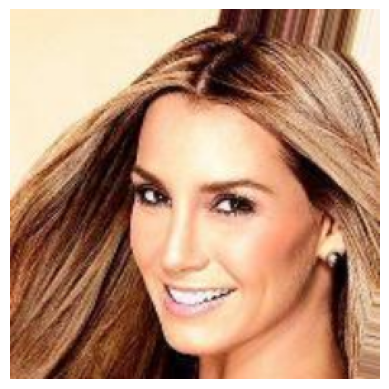

In [ ]:
import matplotlib.pyplot as plt

# Undo normalization for visualization
def denormalize(img_tensor):
    img = img_tensor.clone()
    img = img * 0.5 + 0.5  # [-1,1] → [0,1]
    img = img.permute(1,2,0).cpu().numpy()
    return img

# Display
plt.imshow(denormalize(img))
plt.axis('off')
plt.show()

In [ ]:
relation_map = {
    # Hair Color
    "Black_Hair": "hasHairColor",
    "Blond_Hair": "hasHairColor",
    "Brown_Hair": "hasHairColor",
    "Gray_Hair": "hasHairColor",

    # Hair Style
    "Bald": "hasHairStyle",
    "Bangs": "hasHairStyle",
    "Receding_Hairline": "hasHairStyle",
    "Straight_Hair": "hasHairStyle",
    "Wavy_Hair": "hasHairStyle",

    # Facial Hair
    "5_o_Clock_Shadow": "hasFacialHair",
    "Mustache": "hasFacialHair",
    "Goatee": "hasFacialHair",
    "Sideburns": "hasFacialHair",
    "No_Beard": "hasFacialHair",

    # Facial Features
    "Arched_Eyebrows": "hasFacialFeature",
    "Bushy_Eyebrows": "hasFacialFeature",
    "High_Cheekbones": "hasFacialFeature",
    "Narrow_Eyes": "hasFacialFeature",
    "Big_Nose": "hasFacialFeature",
    "Big_Lips": "hasFacialFeature",
    "Pointy_Nose": "hasFacialFeature",
    "Oval_Face": "hasFacialFeature",
    "Double_Chin": "hasFacialFeature",
    "Chubby": "hasFacialFeature",

    # Accessories
    "Eyeglasses": "wearsAccessory",
    "Wearing_Hat": "wearsAccessory",
    "Wearing_Earrings": "wearsAccessory",
    "Wearing_Necklace": "wearsAccessory",
    "Wearing_Necktie": "wearsAccessory",

    # Makeup
    "Heavy_Makeup": "wearsMakeup",
    "Wearing_Lipstick": "wearsMakeup",

    # Demographics
    "Male": "hasGender",
    "Young": "hasAgeGroup",

    # Expression
    "Smiling": "hasExpression",
    "Mouth_Slightly_Open": "hasExpression",

    # Skin Features
    "Bags_Under_Eyes": "hasSkinFeature",
    "Pale_Skin": "hasSkinFeature",
    "Rosy_Cheeks": "hasSkinFeature",

    # Other (special case)
    "Blurry": "hasImageQuality",
    "Attractive": "hasAttractiveness"
}

In [ ]:
#Now we create KG triples:
	#For every image
	#For every attribute where value == 1 (means attribute is present)
	#Create triple: (Image_ID, Relation, Attribute)


triples = []

for idx, row in celeba_dataset.attr_df.iterrows():
    img_id = idx.split(".")[0]  # "000001" from "000001.jpg"
    img_entity = f"Image_{img_id}"  # e.g., Image_000001

    for attr_name, value in row.items():
        if value == 1:  # Attribute is present
            relation = relation_map.get(attr_name, "hasAttribute")  # default fallback relation
            triples.append((img_entity, relation, attr_name))

In [ ]:
print(f"Total Triples Generated: {len(triples)}")
print(f"Example Triple: {triples[0]}")

Total Triples Generated: 1830201
Example Triple: ('Image_000001', 'hasFacialFeature', 'Arched_Eyebrows')


In [ ]:
!pip install -q pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.3/730.3 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np

# Convert list of triples into a NumPy array
triples_array = np.array(triples)

print("Shape of triples array:", triples_array.shape)
print("Example triple:", triples_array[0])

Shape of triples array: (1830201, 3)
Example triple: ['Image_000001' 'hasFacialFeature' 'Arched_Eyebrows']


In [ ]:
#Load Triples into PyKEEN TriplesFactory

from pykeen.triples import TriplesFactory

# Create a TriplesFactory
tf = TriplesFactory.from_labeled_triples(triples_array)

print(f"Number of Entities: {tf.num_entities}")
print(f"Number of Relations: {tf.num_relations}")
print(f"Number of Triples: {tf.num_triples}")

INFO:pykeen.utils:Using opt_einsum


Number of Entities: 202639
Number of Relations: 12
Number of Triples: 1830201


In [ ]:
from pykeen.pipeline import pipeline

# Define the pipeline
# Split the triples factory into training and testing sets
training_tf, testing_tf = tf.split(ratios=[0.8, 0.2])  # 80% for training, 20% for testing

result = pipeline(
    training=training_tf,
    testing=testing_tf, # Added testing data
    model='TransE',
    model_kwargs={'embedding_dim': 50},
    optimizer='adam',
    training_kwargs={
        'num_epochs': 30,
        'batch_size': 1024,
    }
)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [1261541, 366041]
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


Training epochs on cuda:0:   0%|          | 0/30 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.43k [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/366k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 867.92s seconds


In [ ]:
import torch
model = result.model
torch.save(model.state_dict(), "transe_model.pth")

In [ ]:
# 1. Get the final entity embeddings
entity_embeddings = result.model.entity_representations[0]()  # shape: (num_entities, embedding_dim)

# 2. Entity ID Mapping (string name → integer ID)
entity_to_id = result.training.entity_to_id  # Important: use training_tf entity mapping

# 3. Attribute Names (from your attribute file)
celeba_attributes = celeba_dataset.attr_df.columns.tolist()

In [ ]:
#Building Per-Image 40x50 Vectors

embedding_dim = entity_embeddings.shape[1]  # Should be 50

# Prepare all attribute embeddings first
attr_emb_dict = {}
for attr in celeba_attributes:
    if attr in entity_to_id:
        attr_emb_dict[attr] = entity_embeddings[entity_to_id[attr]].detach().cpu().numpy()
    else:
        print(f"Warning: Attribute {attr} not found in entity list!")  # Should not happen

# Build big attribute vectors for each image
all_image_vectors = []

for idx, row in celeba_dataset.attr_df.iterrows():
    img_vector_parts = []

    for attr_name in celeba_attributes:
        # +1 or -1 based on presence
        attr_value = row[attr_name]

        attr_emb = attr_emb_dict[attr_name]
        weighted_emb = attr_value * attr_emb  # +1 or -1 times the embedding

        img_vector_parts.append(weighted_emb)

    # Concatenate 40 embeddings
    image_vector = np.concatenate(img_vector_parts)  # Final dimension = 40 * 50 = 2000
    all_image_vectors.append(image_vector)

all_image_vectors = np.stack(all_image_vectors)

print("Final per-image vector shape:", all_image_vectors.shape)

Final per-image vector shape: (202599, 2000)


In [ ]:
#Defining the Autoencoder Architecture

import torch.nn as nn

class AttributeAutoencoder(nn.Module):
    def __init__(self, input_dim=2000, latent_dim=128):
        super(AttributeAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim)  # compressed representation
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Tanh()  # because we scaled embeddings between [-1,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed

In [ ]:
#Preparing the Dataset and Dataloader

from torch.utils.data import TensorDataset, DataLoader

# Convert your vectors to a Tensor
X = torch.tensor(all_image_vectors, dtype=torch.float32)

# Wrap in Dataset
dataset = TensorDataset(X)

# Create DataLoader
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Instantiate Model, Loss, and Optimizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on device:", device)

# Create model
autoencoder = AttributeAutoencoder(input_dim=2000, latent_dim=128).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

Training on device: cuda


In [ ]:
#Training the Autoencoder

num_epochs = 50

for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0

    for batch in dataloader:
        x_batch = batch[0].to(device)

        # Forward
        reconstructed = autoencoder(x_batch)

        # Loss
        loss = criterion(reconstructed, x_batch)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.6f}")

Epoch [1/50], Loss: 0.000536
Epoch [2/50], Loss: 0.000040
Epoch [3/50], Loss: 0.000026
Epoch [4/50], Loss: 0.000018
Epoch [5/50], Loss: 0.000014
Epoch [6/50], Loss: 0.000011
Epoch [7/50], Loss: 0.000010
Epoch [8/50], Loss: 0.000008
Epoch [9/50], Loss: 0.000008
Epoch [10/50], Loss: 0.000006
Epoch [11/50], Loss: 0.000007
Epoch [12/50], Loss: 0.000006
Epoch [13/50], Loss: 0.000006
Epoch [14/50], Loss: 0.000004
Epoch [15/50], Loss: 0.000005
Epoch [16/50], Loss: 0.000004
Epoch [17/50], Loss: 0.000010
Epoch [18/50], Loss: 0.000003
Epoch [19/50], Loss: 0.000003
Epoch [20/50], Loss: 0.000003
Epoch [21/50], Loss: 0.000003
Epoch [22/50], Loss: 0.000003
Epoch [23/50], Loss: 0.000003
Epoch [24/50], Loss: 0.000004
Epoch [25/50], Loss: 0.000002
Epoch [26/50], Loss: 0.000002
Epoch [27/50], Loss: 0.000003
Epoch [28/50], Loss: 0.000002
Epoch [29/50], Loss: 0.000002
Epoch [30/50], Loss: 0.000002
Epoch [31/50], Loss: 0.000002
Epoch [32/50], Loss: 0.000002
Epoch [33/50], Loss: 0.000002
Epoch [34/50], Loss

In [ ]:
torch.save(autoencoder.state_dict(), "attribute_autoencoder.pth")

In [ ]:
# Move model to eval mode
autoencoder.eval()

# Example compression
sample_img_vec = X[0].unsqueeze(0).to(device)  # (1, 2000)
compressed_vec = autoencoder.encoder(sample_img_vec)  # (1, 128)

print("Compressed vector shape:", compressed_vec.shape)

Compressed vector shape: torch.Size([1, 128])


In [ ]:
#Installing HuggingFace Diffusers and Required Packages

# Install exact working versions
!pip install diffusers==0.18.2 transformers==4.30.2 accelerate==0.21.0 huggingface_hub==0.15.1